<a href="https://colab.research.google.com/github/AchrafAsh/ml_projects/blob/main/mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TODO

- [x] Image processing: Normalization
- [x] Visualize the data
- [ ] Transfer learning: VGG19 + change last fc layer
- [ ] Image augmentation (⚠️ don't rotate images as they might look like another digit)
- [ ] Add batch normalization
- [ ] Add dropouts
- [ ] Learning rate scheduler
- [ ] Switch to GPU
- [ ] Xavier weight initialization

<br/>

## Architecture
1. 2D convolutional layer
2. Relu
3. Dense layer
4. Sigmoid

Conv2D (same for max pooling): 
$$ H_{out} = \frac{H_{in} + 2 \times padding[0] - dilation[0] \times (kernel\_size[0] - 1) - 1}{stride[0]} + 1 $$

$$ W_{out} = \frac{W_{in} + 2  \times padding[1] - dilation[1] \times (kernel\_size[1] - 1) - 1}{stride[1]} + 1 $$

# Introduction

Using CNN and image processing to solve the classic MNIST classification problem.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from google.colab import drive

In [ ]:
device = "gpu" if torch.cuda.is_available() else "cpu"

In [ ]:
import random
# reproducible results
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

class args:
    seed = 123
    n_gpu = 0

set_seed(args)

## Prepare the data

The data is in a csv file where each column is a pixel of the image (gray scale).
Let's create a custom dataset to rebuild the image from the csv data.

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, root_dir, filename, transform, nrows):
        self.root_dir = root_dir
        self.transform = transform
        self.df = pd.read_csv(os.path.join(root_dir, filename), nrows=nrows)
        self.labels = self.df["label"]
        self.images = self.df.iloc[:, 1:]

    def __len__(self): return len(self.df)

    @staticmethod
    def build_image(pix_arr):
        """Takes a 1D array of pixels and returns a 2D tensor"""
        image = torch.tensor(pix_arr).float()
        image = torch.reshape(image, (1, 28, 28))
        return image
    
    @staticmethod
    def show_image(tensor):
        tensor = torch.reshape(tensor, (28,28))
        npimg = tensor.numpy()
        plt.imshow(npimg)

    def __getitem__(self, idx):
        label = torch.tensor(self.labels.loc[idx])
        image = self.build_image(self.images.loc[idx])
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
def get_loader(batch_size, train=True, num_workers=1, pin_memory=True, transform=None, nrows=None):
    drive.mount("/content/gdrive")

    root_dir = "gdrive/My Drive/Projects/data/mnist"
    if train: filename = "train.csv"
    else: filename = "test.csv"

    dataset = MNISTDataset(root_dir, filename, transform=transform, nrows=nrows)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            num_workers=num_workers, shuffle=train,
                            pin_memory=pin_memory)

    return dataset, dataloader

Normalization:
- mean
- standard deviation

Let's calculate these values

In [ ]:
drive.mount("/content/gdrive")
root_dir = "gdrive/My Drive/Projects/data/mnist"

df = pd.read_csv(os.path.join(root_dir, "train.csv"))
pixels = df.iloc[:, 1:]
sd = pixels.stack().std()
mean = pixels.stack().mean()
print(f"mean: {mean} | standard deviation: {sd}")

Mounted at /content/gdrive
mean: 33.408911169825075 | standard deviation: 78.67774094209487


## Visualize the data

We want our dataset to be well distributed, i.e each label should have roughly the same number of observations. To verify this hypothesis, let's plot a barplot of the number of datapoint per label (from 0 to 9).

In [ ]:
import seaborn as sns
dataset, dataloader = get_loader(batch_size=1)

In [ ]:
dataset[0][1].item()
y = [0] * 10
for i in range(len(dataset)):
    label = dataset[i][1].item()
    y[label] += 1

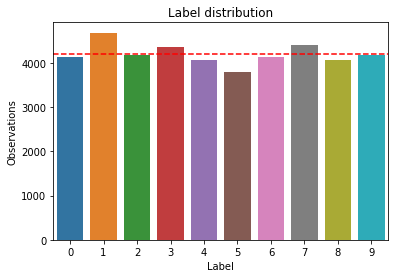

In [ ]:
ax = sns.barplot(x=np.arange(0,10), y=y)
ax.set(title="Label distribution", xlabel="Label", ylabel="Observations")
ax.axhline(np.mean(y), ls='--', color="red")

We can reasonably say that our dataset is uniformly distributed (red line represents the mean). Label 5 is under-represented and the label 1 is over-represented.

# Model definition

In [ ]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=19, stride=1, padding=0) # output (batch_size, 1, )
        self.dense = nn.Linear(in_features=10, out_features=1)
        self.batch_norm = nn.BatchNorm2d(num_features=1)
    
    def forward(self, image):
        batch_size = image.shape[0]
        output = F.relu(self.batch_norm(self.conv(image)))
        output = self.batch_norm(self.dense(output))
        output = torch.reshape(output, (batch_size, 10))
        output = F.softmax(output, dim=1)
        return output
        
    def fit(self, dataset, num_epochs, lr, device="cpu"):
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(num_epochs):
            total_loss = 0
            accuracy = 0

            for _, (images, targets) in enumerate(dataset):
                images = images.to(device)
                labels = self.forward(images)
                
                loss = criterion(labels, targets)
                accuracy = sum(torch.argmax(labels, dim=1) == targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss
            
            if (epoch % 1 == 0): print(f"epoch [{epoch+1} / {num_epochs}] | total loss: {total_loss} | accuracy: {accuracy / (len(dataset) * dataset.batch_size)}")


## Train the model

In [ ]:
# Parameters
BATCH_SIZE=12
NUM_EPOCHS=2
LEARNING_RATE=0.01

### Load the data

In [ ]:
dataset, dataloader = get_loader(batch_size=BATCH_SIZE, transform=transforms.Normalize(mean, sd), nrows=2000)

NameError: ignored

Text(0.5, 1.0, '1')

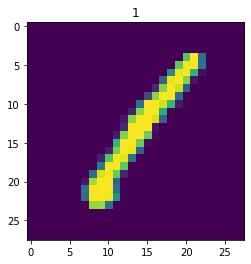

In [ ]:
image, label = dataset[0]
dataset.show_image(image)
plt.title(label.item())

In [ ]:
model = MNISTClassifier().to(device)

In [ ]:
model.fit(dataloader, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device)

epoch [1 / 2] | total loss: 11492.09375 | accuracy: 2.380952355451882e-05
epoch [2 / 2] | total loss: 11356.841796875 | accuracy: 9.523809421807528e-05
